# Importing modules

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# 1. Importing the dataset and data inspection

In [3]:
cntry_df = pd.read_csv(r'https://cdn.upgrad.com/UpGrad/temp/2f181ade-814a-430a-b721-769d6a9bf814/Country-data.csv')
cntry_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
cntry_df.dtypes

country        object
child_mort    float64
exports       float64
health        float64
imports       float64
income          int64
inflation     float64
life_expec    float64
total_fer     float64
gdpp            int64
dtype: object

- All features except country are numerical as expected

In [5]:
cntry_df.shape

(167, 10)

In [6]:
cntry_df.country.nunique()

167

- No of unique entries in country column and number of rows in dataframe are equal. Which means that there are no multiple entries

In [7]:
cntry_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [8]:
cntry_df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

- No null values in the dataframe

In [9]:
cntry_df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


### INSIGHT
   - Dataframe describes various socio-economic factors of 167 different countries.
   - Dataframe has no multiple entries and no null values
   - All features except 'country' are numerical as expected. So, no need of any type casting
   - Descriptive statistics indicates that there is some variability in the data and requires scaling while model building.

## 2. Data Transformation

### INSIGHT
- In the dataframe(cntry_df) provided, `imports`,`exports` and `health` features have the percentage of money spent or gained from these sectors from the total gdpp which is not clear. So, to avoid this, values in `imports`, `exports` and `health` are converted to absolute values

In [10]:
for i in ['imports','exports','health']:
    cntry_df[i] = (cntry_df[i] * cntry_df['gdpp'])/100
cntry_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


## 2.1 Outlier Treatment

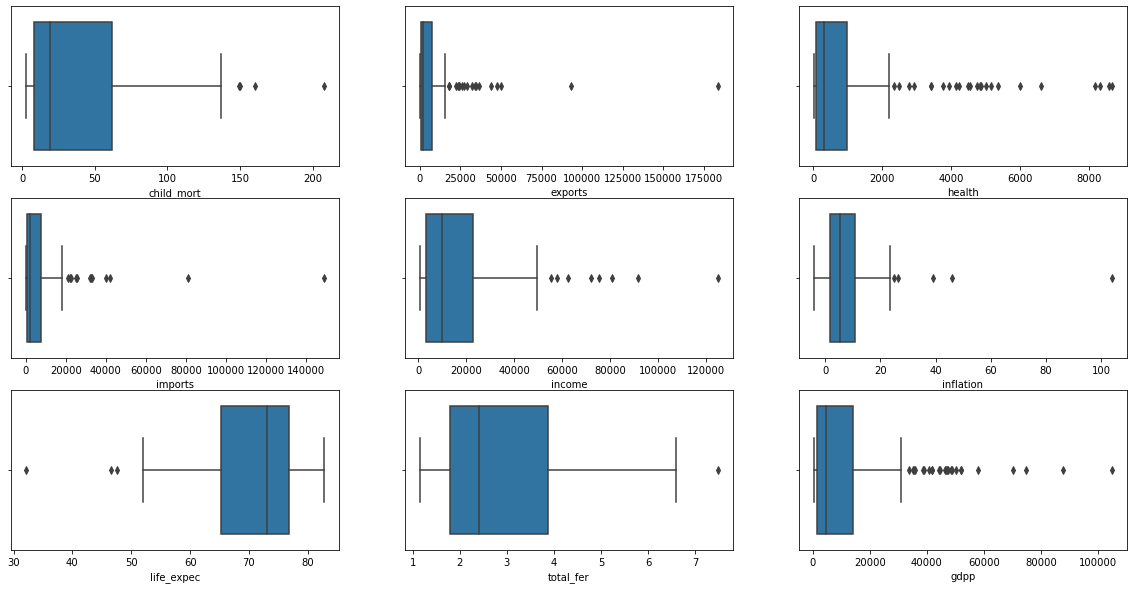

In [11]:
# checking the outliers

plt.figure(figsize = (20,10))

for i in enumerate(cntry_df.columns[1:]): # first column is 'country'. So, dropped it.
    plt.subplot(3,3,i[0]+1)
    sns.boxplot(cntry_df[i[1]])

`OBSERVATIONS:`
   - There are outliers in all features. 
   - We cannot cap the outliers in all features because is leads to deletion of some countries which are actually in dire need of aidand should be in prime focus.
   - So, I've decided to go with the model which suites the Business Problem better. That is, not to treat the Outlier, and check the model with different K values to see which one gives a better business outcome.

## 3. Exploratory Data Analysis
- `Visualizing Distribution`

Plotting a pairplot

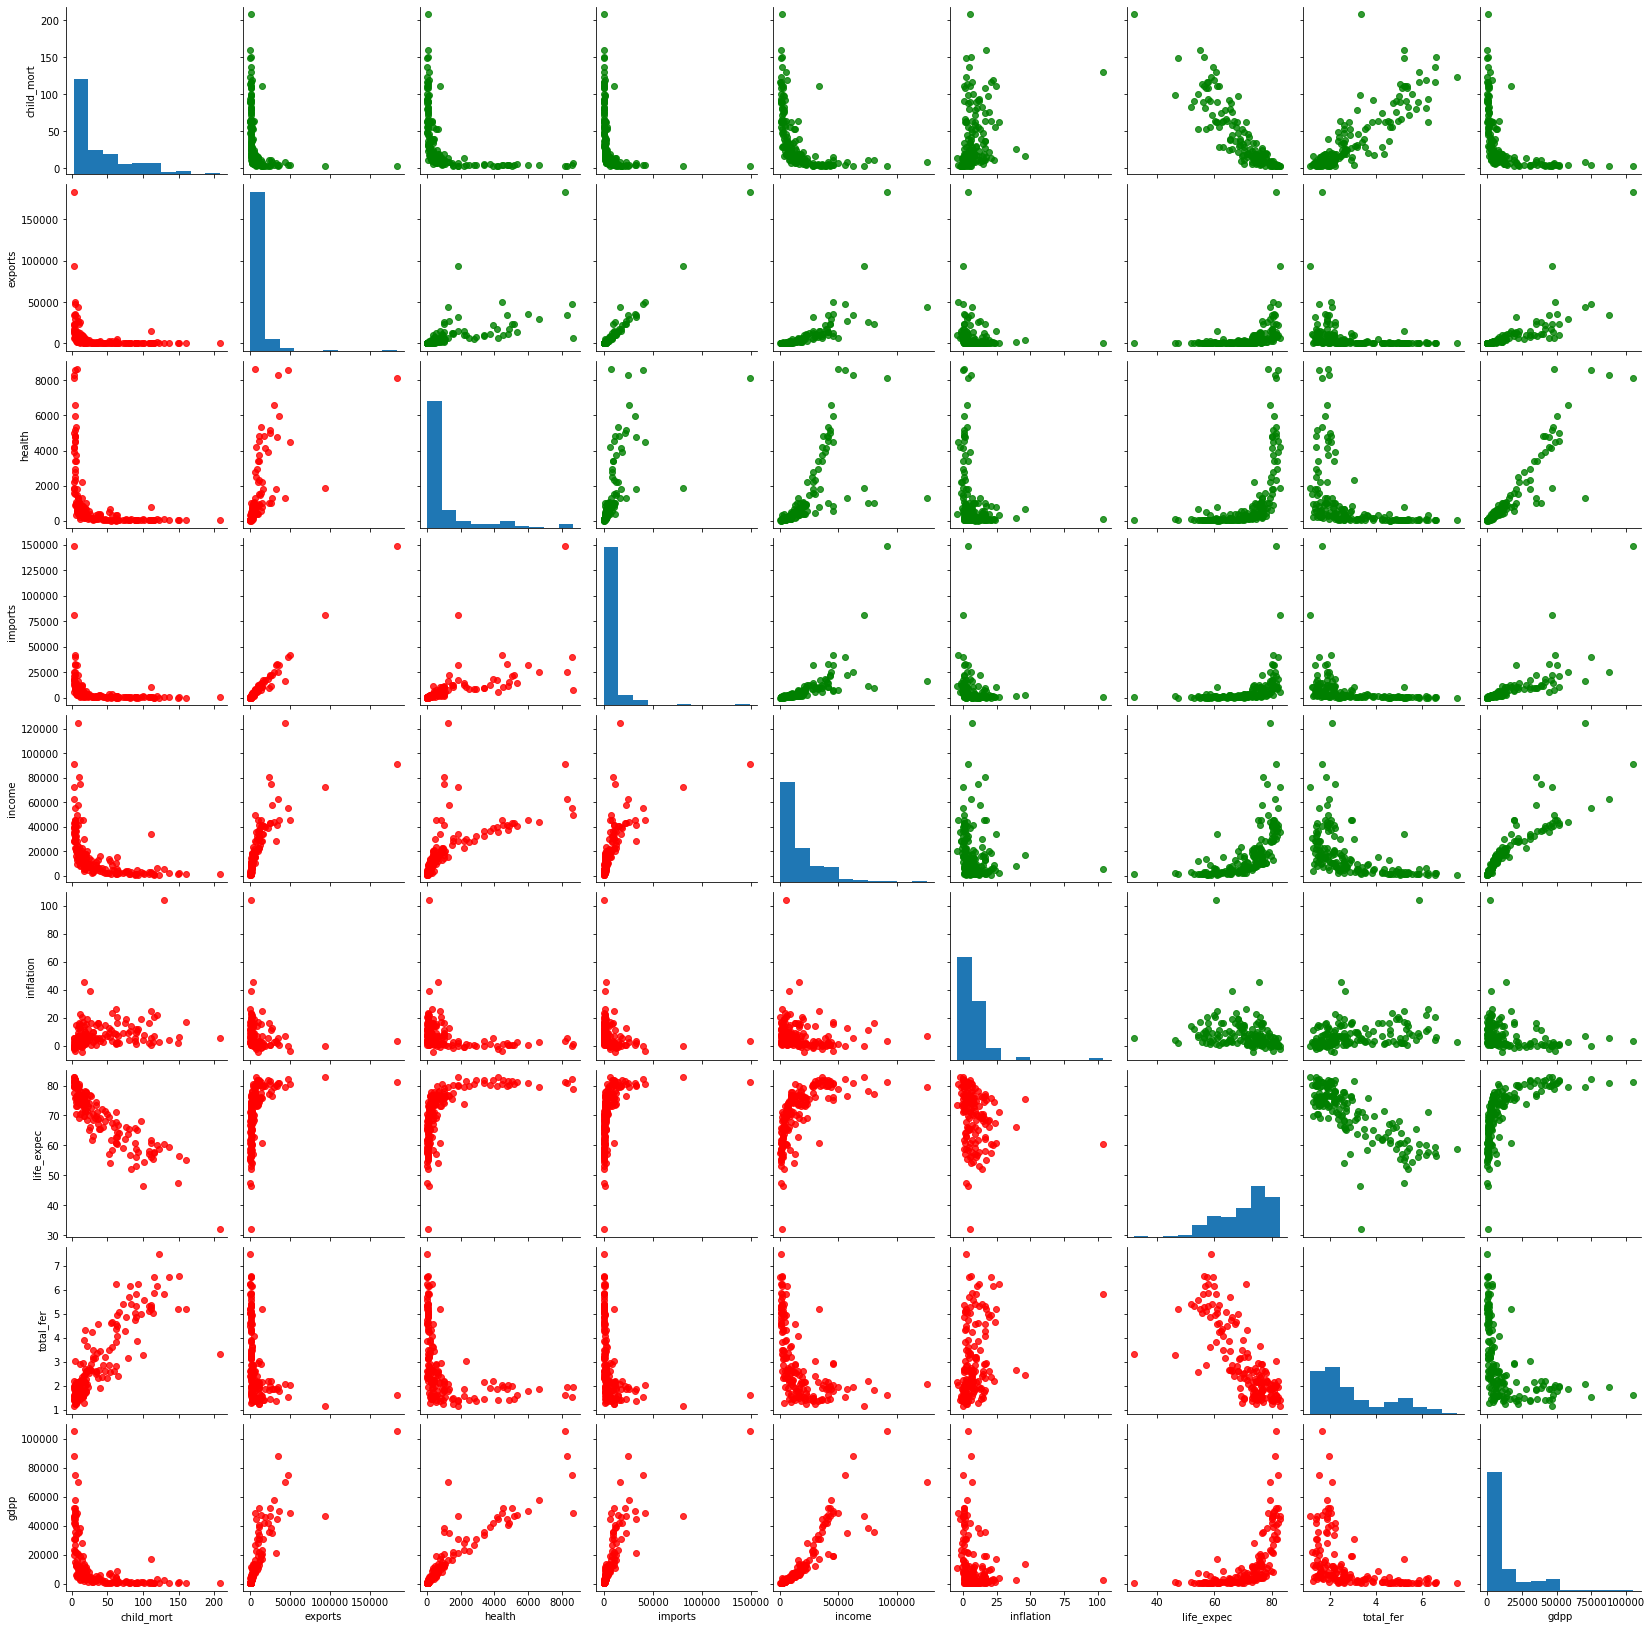

In [12]:
num_df = cntry_df[['child_mort', 'exports', 'health', 'imports', 'income', 'inflation','life_expec', 'total_fer', 'gdpp']
]
pair = sns.PairGrid(num_df)
pair.map_upper(sns.regplot,color ='green', fit_reg = False)
pair.map_lower(sns.regplot, color ='red', fit_reg = False)
pair.map_diag(plt.hist)
plt.show()

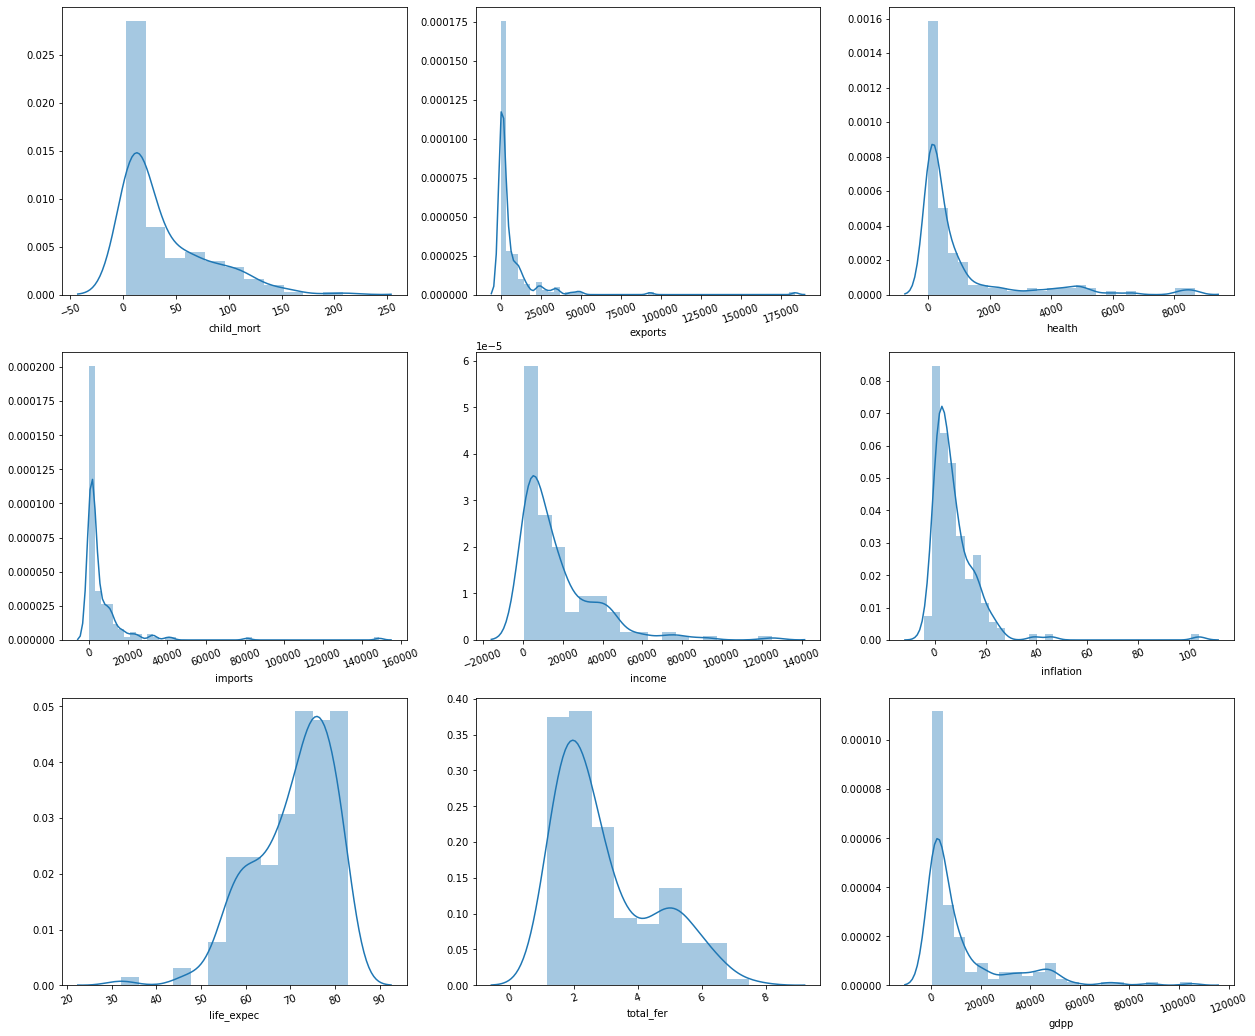

In [13]:
plt.figure(figsize=(21, 18))
features = ['child_mort', 'exports', 'health', 'imports', 'income','inflation', 'life_expec', 'total_fer', 'gdpp']
for i in enumerate(features):
    ax = plt.subplot(3, 3, i[0]+1)
    sns.distplot(num_df[i[1]])
    plt.xticks(rotation=20)

### INSIGHT:
   - Majority of the data points are `not normally distributed`. 
   - Variance is not uniform and range is not same for all features.
   - We need to standardize data to overcome all this. Since we need to calculate the Euclidean distance between the data points for clustering, it is important to ensure that the values with high range do not outweigh the values with smaller range. Thus, scaling down all the attributes to a uniform scale is important.

### SCALING THE DATA (STANDARDIZATION) 
    - We will use standardization method for scaling the data.

In [14]:
new_cntry_df = cntry_df[cntry_df.columns[cntry_df.dtypes != 'object']]
new_cntry_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   child_mort  167 non-null    float64
 1   exports     167 non-null    float64
 2   health      167 non-null    float64
 3   imports     167 non-null    float64
 4   income      167 non-null    int64  
 5   inflation   167 non-null    float64
 6   life_expec  167 non-null    float64
 7   total_fer   167 non-null    float64
 8   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 11.9 KB


In [15]:
new_cntry_df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,183750.000000,8663.600000,149100.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


`Rescaling the data`

In [16]:
# instantiate 
scaler = StandardScaler()

# fit_transform
scaled_data = pd.DataFrame(scaler.fit_transform(new_cntry_df))

scaled_data.columns = cntry_df.columns[cntry_df.dtypes != 'object']

scaled_data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-0.411011,-0.565040,-0.432276,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.350191,-0.439218,-0.313677,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.318526,-0.484826,-0.353720,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,-0.291375,-0.532363,-0.345953,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,-0.104331,-0.178771,0.040735,0.101732,-0.601749,0.704258,-0.541946,-0.041817


### HOPKINS STATISTICS
   - Before applying clustering on a dataframe, first we need to check whether has some meaningful(not occuring at random) clusters.
   - The process of evaluating data whether clustering can be applied or not is called `Clustering Tendency`.
   - For `clustering tendency`, we use `Hopkins Test` which examines whether the data points differ significantly from uniformly distributed data in the multidimensional space.

In [17]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins_test(X):
    d = X.shape[1]
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [18]:
#Using the Hopkins Statistic function by passing the above dataframe as a parameter
hopkins_test(scaled_data)

0.9457101803350613

### INSIGHT
   - If the value is between {0.01, ...,0.3}, the data is regularly spaced (normally distributed).
   - If the value is around 0.5, it is random.
   - If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster. 

# 4. Model building
## 4.1 Hierarchial Clustering

- We use Hierarchial clusterign approach to identify appropriate cluster size with a good split in data
    - Max Intra-cluster distance and Min Inter-cluster distance

### Single linkage
   - Here, the distance between 2 clusters is defined as the shortest distance between points in the two clusters.

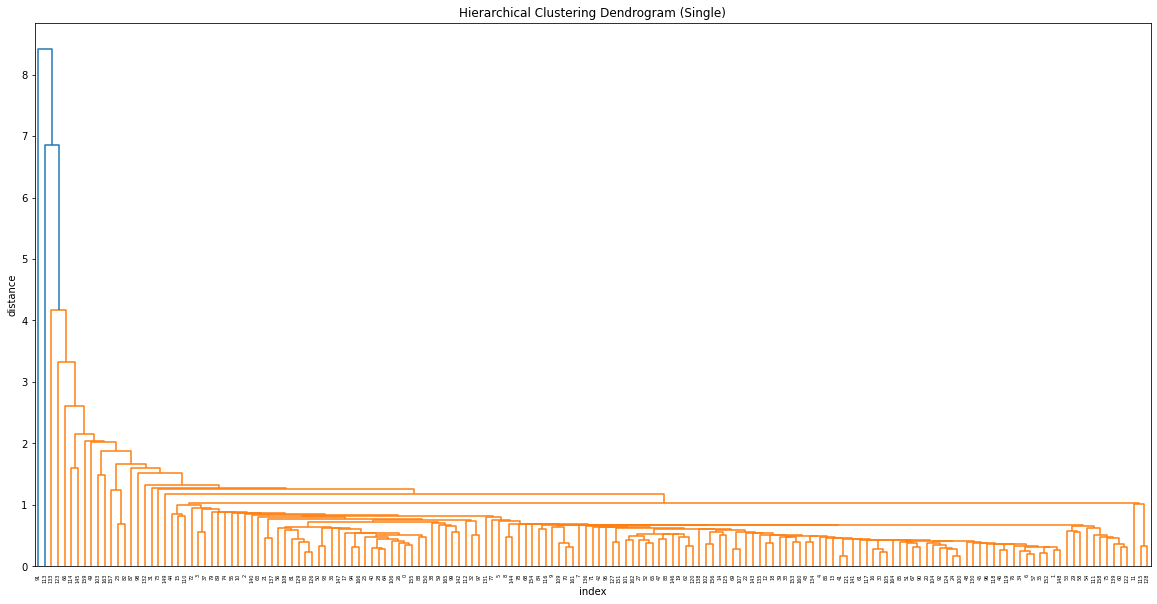

In [19]:
plt.figure(figsize=(20, 10))
plt.title('Hierarchical Clustering Dendrogram (Single)')
plt.xlabel('index')
plt.ylabel('distance')
merging_s = linkage(scaled_data, method="single", metric='euclidean')
dendrogram(merging_s)
plt.show()

### complete linkage :
- Here, the distance between 2 clusters is defined as the maximum distance between any 2 points in the clusters.


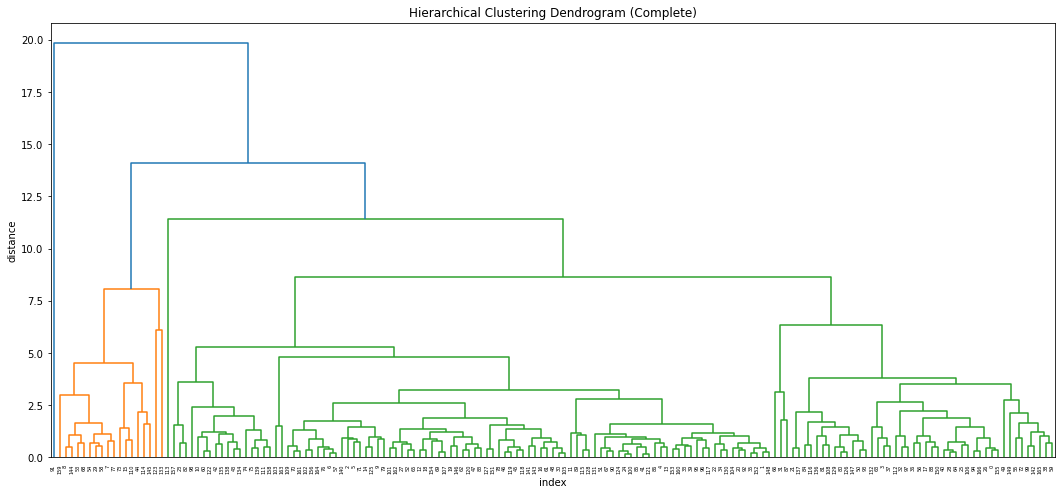

In [20]:
plt.figure(figsize=(18, 8))
plt.title('Hierarchical Clustering Dendrogram (Complete)')
plt.xlabel('index')
plt.ylabel('distance')
merging_c = linkage(scaled_data, method="complete", metric='euclidean')
dendrogram(merging_c)
plt.show()

####  `NOTE`
- From the above two dendrograms, it is clear that `Complete Linkage` has a batter cluster formation.
- So, we will use `Complete linkage` output for further analysis. We will build two iterations of clustering
    - one with 3 clusters and another one with 4 clusters (based on the output from Complete Linkage Dendrogram) and analyze the output
    

#### First iteration - Using 3 clusters

In [21]:
cluster_label_3 = cut_tree(merging_c, n_clusters = 3).reshape(-1,)
cluster_label_3

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [22]:
# creating a dataframe with cluster labels on it

cntry_data_h = cntry_df.copy()
cntry_data_h['cluster_label_3'] = cluster_label_3
cntry_data_h.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_label_3
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,0


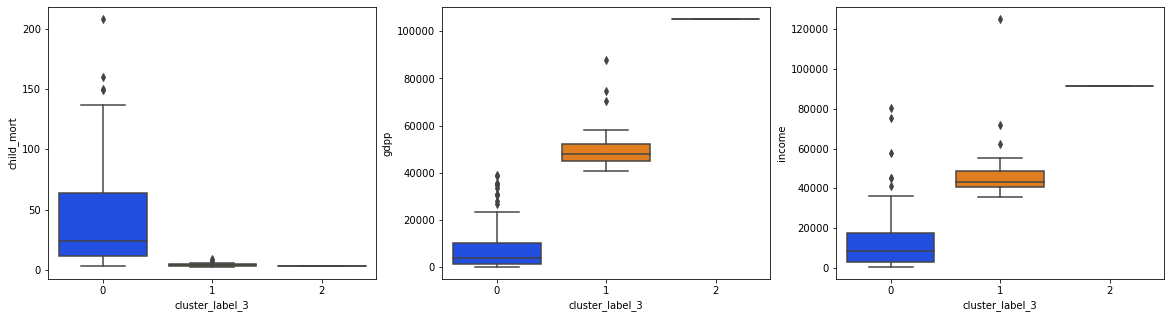

In [23]:
# Box plot on various features against the CLUSTER_ID to visualize the spread of the data

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='cluster_label_3', y='child_mort', data=cntry_data_h, palette="bright")
plt.subplot(1, 3, 2)
sns.boxplot(x='cluster_label_3', y='gdpp', data=cntry_data_h, palette="bright")
plt.subplot(1, 3, 3)
sns.boxplot(x='cluster_label_3', y='income', data=cntry_data_h, palette="bright")

plt.show()

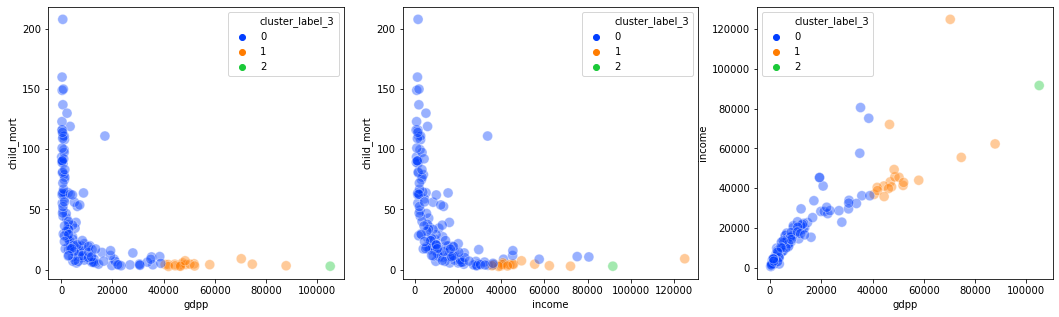

In [24]:
# plotting scatter plot on various features to visualize the clusters based on them

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x='gdpp', y='child_mort', hue='cluster_label_3',
                data=cntry_data_h, legend='full', palette="bright", s=100, c='lightblue', alpha=.4)
plt.subplot(1, 3, 2)
sns.scatterplot(x='income', y='child_mort', hue='cluster_label_3',
                data=cntry_data_h, legend='full', palette="bright", s=100, c='lightblue', alpha=.4)
plt.subplot(1, 3, 3)
sns.scatterplot(x='gdpp', y='income', hue='cluster_label_3',
                data=cntry_data_h, legend='full', palette="bright", s=100, c='lightblue', alpha=.4)
plt.show()

In [25]:
# checking cluster count

cntry_data_h.cluster_label_3.value_counts()

0    148
1     18
2      1
Name: cluster_label_3, dtype: int64

In [26]:
# checking countries in cluster 2 

cntry_data_h[cntry_data_h['cluster_label_3'] == 2]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_label_3
91,Luxembourg,2.8,183750.0,8158.5,149100.0,91700,3.62,81.3,1.63,105000,2


In [27]:
# checking countries in cluster 1

cntry_data_h[cntry_data_h['cluster_label_3'] == 1]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_label_3
7,Australia,4.8,10276.2,4530.87,10847.1,41400,1.160,82.0,1.93,51900,1
8,Austria,4.3,24059.7,5159.00,22418.2,43200,0.873,80.5,1.44,46900,1
15,Belgium,4.5,33921.6,4750.80,33166.8,41100,1.880,80.0,1.86,44400,1
29,Canada,5.6,13793.4,5356.20,14694.0,40700,2.870,81.3,1.63,47400,1
44,Denmark,4.1,29290.0,6612.00,25288.0,44000,3.220,79.5,1.87,58000,1
53,Finland,3.0,17879.4,4134.90,17278.8,39800,0.351,80.0,1.87,46200,1
54,France,4.2,10880.8,4831.40,11408.6,36900,1.050,81.4,2.03,40600,1
58,Germany,4.2,17681.4,4848.80,15507.8,40400,0.758,80.1,1.39,41800,1
68,Iceland,2.6,22374.6,3938.60,18142.7,38800,5.470,82.0,2.20,41900,1
73,Ireland,4.2,50161.0,4475.53,42125.5,45700,-3.220,80.4,2.05,48700,1


- Clusters 1 and 2 are developed and developing countries. So, our segmentation is good in terms of all our under developed countries are segmented under cluster 0. We will further tune this cluster

#### Second iteration - Using 4 clusters

In [28]:
# 4 Clusters
cluster_label_4 = cut_tree(merging_c, n_clusters = 4).reshape(-1,)
cluster_label_4

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [29]:
cntry_data_h['cluster_label_4'] = cluster_label_4

cntry_data_h.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_label_3,cluster_label_4
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,0,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,0,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,0,0


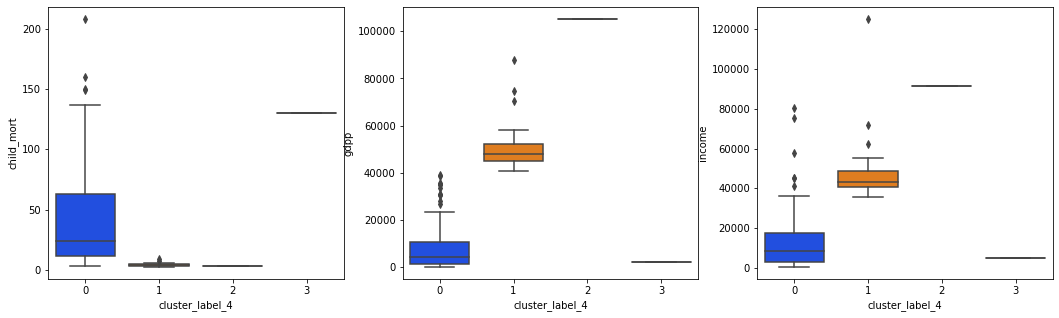

In [30]:
# Box plot on various variable against the CLUSTER_ID to visualize the spread of the data

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='cluster_label_4', y='child_mort', data=cntry_data_h, palette="bright")
plt.subplot(1, 3, 2)
sns.boxplot(x='cluster_label_4', y='gdpp', data=cntry_data_h, palette="bright")
plt.subplot(1, 3, 3)
sns.boxplot(x='cluster_label_4', y='income', data=cntry_data_h, palette="bright")

plt.show()

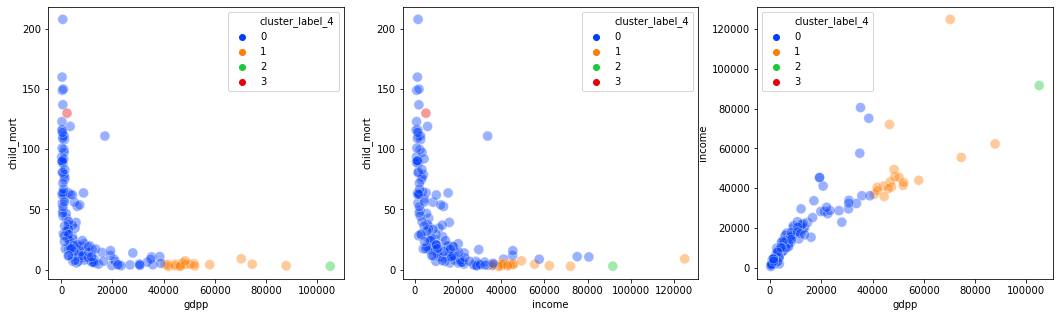

In [31]:
# Scatter plot on various variables to visualize the clusters based on them

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x='gdpp', y='child_mort', hue='cluster_label_4',
                data=cntry_data_h, legend='full', palette="bright", s=100, c='lightblue', alpha=.4)
plt.subplot(1, 3, 2)
sns.scatterplot(x='income', y='child_mort', hue='cluster_label_4',
                data=cntry_data_h, legend='full', palette="bright", s=100, c='lightblue', alpha=.4)
plt.subplot(1, 3, 3)
sns.scatterplot(x='gdpp', y='income', hue='cluster_label_4',
                data=cntry_data_h, legend='full', palette="bright", s=100, c='lightblue', alpha=.4)
plt.show()

In [32]:
cntry_data_h.cluster_label_4.value_counts()

0    147
1     18
3      1
2      1
Name: cluster_label_4, dtype: int64

In [33]:
# Checking the countries in Cluster 2 to see which are the countries in that segment.

cntry_data_h[cntry_data_h['cluster_label_4'] == 2]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_label_3,cluster_label_4
91,Luxembourg,2.8,183750.0,8158.5,149100.0,91700,3.62,81.3,1.63,105000,2,2


In [34]:
# Checking the countries in Cluster 3 to see which are the countries in that segment.

cntry_data_h[cntry_data_h['cluster_label_4'] == 3]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_label_3,cluster_label_4
113,Nigeria,130.0,589.49,118.131,405.42,5150,104.0,60.5,5.84,2330,0,3


In [35]:
# Checking the countries in Cluster 1 to see which are the countries in that segment.

cntry_data_h[cntry_data_h['cluster_label_4'] == 1]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_label_3,cluster_label_4
7,Australia,4.8,10276.2,4530.87,10847.1,41400,1.160,82.0,1.93,51900,1,1
8,Austria,4.3,24059.7,5159.00,22418.2,43200,0.873,80.5,1.44,46900,1,1
15,Belgium,4.5,33921.6,4750.80,33166.8,41100,1.880,80.0,1.86,44400,1,1
29,Canada,5.6,13793.4,5356.20,14694.0,40700,2.870,81.3,1.63,47400,1,1
44,Denmark,4.1,29290.0,6612.00,25288.0,44000,3.220,79.5,1.87,58000,1,1
53,Finland,3.0,17879.4,4134.90,17278.8,39800,0.351,80.0,1.87,46200,1,1
54,France,4.2,10880.8,4831.40,11408.6,36900,1.050,81.4,2.03,40600,1,1
58,Germany,4.2,17681.4,4848.80,15507.8,40400,0.758,80.1,1.39,41800,1,1
68,Iceland,2.6,22374.6,3938.60,18142.7,38800,5.470,82.0,2.20,41900,1,1
73,Ireland,4.2,50161.0,4475.53,42125.5,45700,-3.220,80.4,2.05,48700,1,1


#### INSIGHT
   - From the 2 iterations above, we can conclude that `3 clusters` is ideal for number of clusters.
   - This is because for `4 clusters`, `nigeria` was added as a separate cluster. Since Nigeria could be a backward country which may need the aid in terms of it's child mortality rate. 
   - So, the ideal number of clusters is `3 clusters`. We will further validate this.

### Interpreting Clusters from the Hierarchial Clustering model

In [36]:
cntry_data_h_analysis = cntry_data_h.groupby(['cluster_label_3']).mean()
cntry_data_h_analysis

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_label_4
cluster_label_3,,,,,,,,,,
0,42.630405,3598.749645,511.946183,3451.232447,12641.641892,8.561986,69.224324,3.098851,7551.445946,0.02027
1,4.388889,29048.800000,5141.550556,24465.133333,50027.777778,1.598444,80.905556,1.780556,52355.555556,1.00000
2,2.800000,183750.000000,8158.500000,149100.000000,91700.000000,3.620000,81.300000,1.630000,105000.000000,2.00000


In [37]:
# Creating a new field for count of observations in each cluster
cntry_data_h_analysis['Observations']=cntry_data_h[['cluster_label_3','child_mort']].groupby(['cluster_label_3']).count()
cntry_data_h_analysis

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_label_4,Observations
cluster_label_3,,,,,,,,,,,
0,42.630405,3598.749645,511.946183,3451.232447,12641.641892,8.561986,69.224324,3.098851,7551.445946,0.02027,148
1,4.388889,29048.800000,5141.550556,24465.133333,50027.777778,1.598444,80.905556,1.780556,52355.555556,1.00000,18
2,2.800000,183750.000000,8158.500000,149100.000000,91700.000000,3.620000,81.300000,1.630000,105000.000000,2.00000,1


In [38]:
# Creating a new field for proportion of observations in each cluster
cntry_data_h_analysis['Proportion']=round(cntry_data_h_analysis['Observations']/cntry_data_h_analysis['Observations'].sum(),2)
cntry_data_h_analysis

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_label_4,Observations,Proportion
cluster_label_3,,,,,,,,,,,,
0,42.630405,3598.749645,511.946183,3451.232447,12641.641892,8.561986,69.224324,3.098851,7551.445946,0.02027,148,0.89
1,4.388889,29048.800000,5141.550556,24465.133333,50027.777778,1.598444,80.905556,1.780556,52355.555556,1.00000,18,0.11
2,2.800000,183750.000000,8158.500000,149100.000000,91700.000000,3.620000,81.300000,1.630000,105000.000000,2.00000,1,0.01


<Figure size 720x360 with 0 Axes>

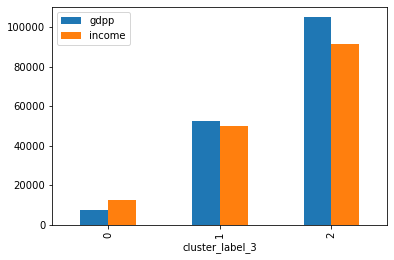

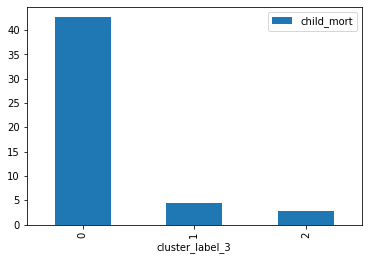

In [39]:
plt.figure(figsize=(10, 5))
cntry_data_h_plot1=cntry_data_h[['cluster_label_3','gdpp','income']].copy()
cntry_data_h_plot1=cntry_data_h_plot1.groupby('cluster_label_3').mean()
cntry_data_h_plot1.plot.bar()

cntry_data_h_plot2=cntry_data_h[['cluster_label_3','child_mort']].copy()
cntry_data_h_plot2=cntry_data_h_plot2.groupby('cluster_label_3').mean()
cntry_data_h_plot2.plot.bar()
plt.show()

### Interpretation of Clusters: 
   - `Cluster 0` has the highest average child mortality rate of ~42 when compared to other 2 clusters and `lowest gdpp` and `lowest income` of ~7551 & 12641 respectively.
   - All the above reasons make the `cluster 0` ideal for the requirement. We can also observe that cluster 0 comprises of ~89% of overall countries and has ~148 countries out of 167 total countries. This is a problem.
   - Clustering model is not giving us a good result because ~89% of data is under one cluster and increasing the number of clusters doesn't solve this problem. We will check K-Means clustering.

## Finding the Optimal Number of Clusters
### SSD (Elbow curve)

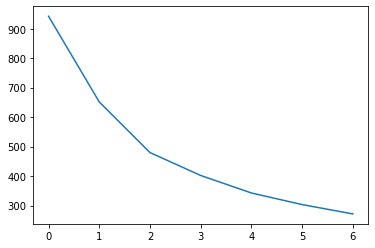

In [40]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(scaled_data)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

### Silhouette Analysis
`                                   silhouette score = p−q/max(p,q)`
 
- p  is the mean distance to the points in the nearest cluster that the data point is not a part of
- q  is the mean intra-cluster distance to all the points in its own cluster.
- The value of the silhouette score range lies between -1 to 1.
- A score closer to 1 indicates that the data point is very similar to other data points in the cluster,
- A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [41]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(scaled_data)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.45863306035476264
For n_clusters=3, the silhouette score is 0.4218615812599681
For n_clusters=4, the silhouette score is 0.42914711278370843
For n_clusters=5, the silhouette score is 0.43077513396770467
For n_clusters=6, the silhouette score is 0.3956204033435846
For n_clusters=7, the silhouette score is 0.30682203825187315
For n_clusters=8, the silhouette score is 0.2682369198227175


#### INSIGHT:
   - From the above validations (Elbow curve and Silhouette analysis), we can notice that 3,4 & 5 are the optimal number of clusters. We will do 3 iterations for 3,4 & 5 clusters.

### 4.2 K-MEANS CLUSTERING 

#### First iteration - 3 Clusters

In [42]:
# K Means with with k=3
kmeans_3 = KMeans(n_clusters=3, max_iter=500, init='k-means++', n_init=10, random_state= 335)
kmeans_3.fit(scaled_data)
kmeans_3.labels_

array([2, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2,
       0, 1, 0, 2, 2, 0, 2, 1, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 1, 0,
       1, 0, 0, 0, 0, 2, 2, 0, 0, 1, 1, 2, 2, 0, 1, 2, 0, 0, 0, 2, 2, 0,
       2, 0, 1, 0, 0, 0, 2, 1, 0, 1, 0, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2,
       2, 0, 0, 1, 0, 2, 2, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       1, 1, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0,
       2, 1, 0, 0, 2, 2, 0, 1, 0, 0, 2, 0, 1, 1, 0, 2, 0, 2, 2, 0, 0, 0,
       0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2])

In [43]:
# Create a new datafame with scaled data and adding country name to it.
cntry_data_k = cntry_data_h.copy()
cntry_data_k.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_label_3,cluster_label_4
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,0,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,0,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,0,0


In [44]:
# assigning the label
cntry_data_k['cluster_id_3'] = kmeans_3.labels_
cntry_data_k.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_label_3,cluster_label_4,cluster_id_3
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,0,0,2
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,0,0,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,0,0,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,0,0,2
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,0,0,0


In [45]:
# Checking the number of countries in each cluster
cntry_data_k.cluster_id_3.value_counts()

0    91
2    48
1    28
Name: cluster_id_3, dtype: int64

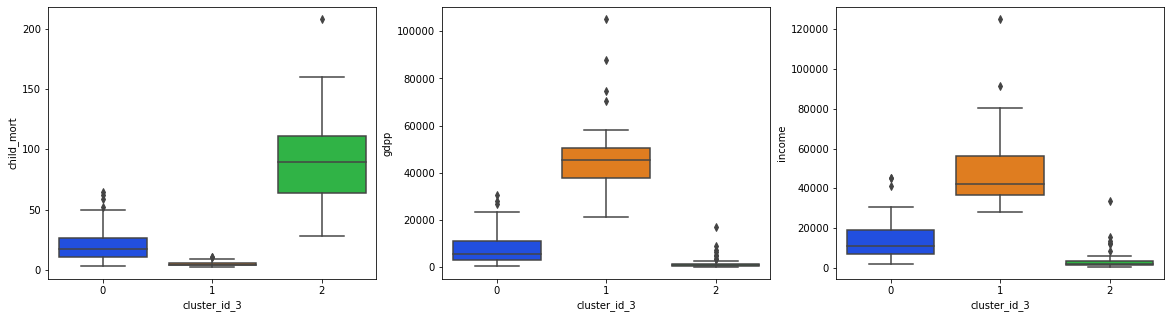

In [46]:
# Box plot on various variable against the CLUSTER_ID to visualize the spread of the data

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='cluster_id_3', y='child_mort',
            data=cntry_data_k, palette="bright")
plt.subplot(1, 3, 2)
sns.boxplot(x='cluster_id_3', y='gdpp',
            data=cntry_data_k, palette="bright")
plt.subplot(1, 3, 3)
sns.boxplot(x='cluster_id_3', y='income',
            data=cntry_data_k, palette="bright")

plt.show()

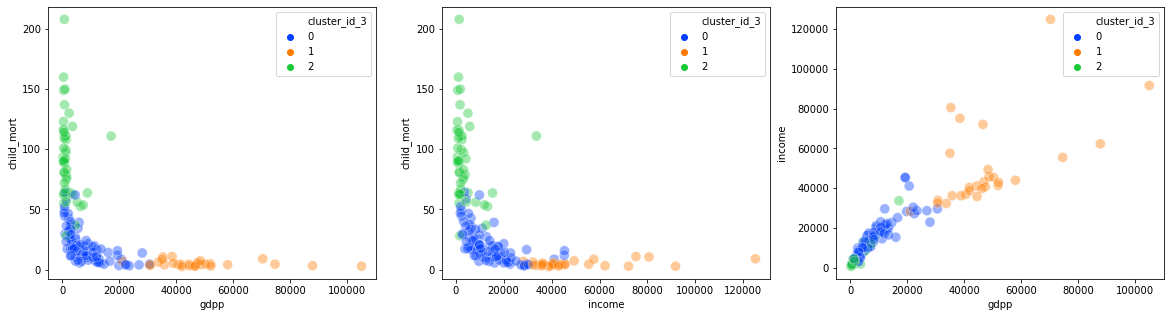

In [47]:
# Scatter plot on various variables to visualize the clusters based on them

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x='gdpp', y='child_mort', hue='cluster_id_3',
                data=cntry_data_k, legend='full', palette="bright", s=100, c='lightblue', alpha=.4)
plt.subplot(1, 3, 2)
sns.scatterplot(x='income', y='child_mort', hue='cluster_id_3',
                data=cntry_data_k, legend='full', palette="bright", s=100, c='lightblue', alpha=.4)
plt.subplot(1, 3, 3)
sns.scatterplot(x='gdpp', y='income', hue='cluster_id_3',
                data=cntry_data_k, legend='full', palette="bright", s=100, c='lightblue', alpha=.4)
plt.show()

In [48]:
# Checking the CLuster means:
cntry_data_k.groupby(['cluster_id_3']).mean().sort_values(['child_mort','income','gdpp'],ascending = [False,True,True])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_label_3,cluster_label_4
cluster_id_3,,,,,,,,,,,
2,91.610417,879.063521,114.821765,827.028771,3897.354167,11.911146,59.239583,4.992083,1909.208333,0.000000,0.062500
0,20.357143,3604.149434,547.279455,3710.446386,13968.021978,7.070549,73.460440,2.235055,7979.912088,0.000000,0.000000
1,5.046429,31038.239286,4327.163214,25818.100000,50178.571429,3.014679,80.514286,1.760714,48114.285714,0.714286,0.714286


### INSIGHT: 
- `cluster 2` and `cluster 0` seems to have highest child mortality rate and lowest income and lowest GDPP. Checking the countries in both clusters.

In [49]:
# Checking the countries in Cluster 2 to see which are the countries in that segment.

cntry_data_k[['country','child_mort','income','gdpp']][cntry_data_k['cluster_id_3'] == 2].sort_values(['child_mort','income','gdpp'],ascending = [False,True,True])

,country,child_mort,income,gdpp
66,Haiti,208.0,1500,662
132,Sierra Leone,160.0,1220,399
32,Chad,150.0,1930,897
31,Central African Republic,149.0,888,446
97,Mali,137.0,1870,708
113,Nigeria,130.0,5150,2330
112,Niger,123.0,814,348
3,Angola,119.0,5900,3530
37,"Congo, Dem. Rep.",116.0,609,334
25,Burkina Faso,116.0,1430,575


In [50]:
# Checking the countries in Cluster 0 to see which are the countries in that segment.

cntry_data_k[['country','child_mort','income','gdpp']][cntry_data_k['cluster_id_3'] == 0].sort_values(['child_mort','income','gdpp'],ascending = [False,True,True])

,country,child_mort,income,gdpp
107,Myanmar,64.4,3720,988
154,Turkmenistan,62.0,9940,4440
69,India,58.8,4410,1350
146,Tajikistan,52.4,2110,738
12,Bangladesh,49.4,2440,758
...,...,...,...,...
138,South Korea,4.1,30400,22100
122,Portugal,3.9,27200,22500
60,Greece,3.9,28700,26900
43,Czech Republic,3.4,28300,19800


#### Second Iteration - 4 clusters

In [51]:
# K Means with with k=4
kmeans_4 = KMeans(n_clusters=4, max_iter=500, init='k-means++', n_init=10, random_state= 335)
kmeans_4.fit(scaled_data)
kmeans_4.labels_

array([3, 1, 1, 3, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 3,
       1, 2, 1, 3, 3, 1, 3, 2, 1, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 1, 2, 1,
       2, 1, 1, 1, 1, 3, 3, 1, 1, 2, 2, 3, 3, 1, 2, 3, 2, 1, 1, 3, 3, 1,
       3, 1, 2, 1, 1, 1, 3, 2, 2, 2, 1, 2, 1, 1, 3, 3, 2, 1, 3, 1, 1, 3,
       3, 1, 1, 0, 1, 3, 3, 1, 1, 3, 2, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1,
       2, 2, 3, 3, 2, 1, 3, 1, 1, 1, 1, 1, 2, 2, 1, 1, 3, 1, 1, 3, 1, 1,
       3, 0, 1, 2, 3, 3, 1, 2, 1, 1, 3, 1, 2, 2, 1, 3, 1, 3, 3, 1, 1, 1,
       1, 3, 1, 2, 2, 2, 1, 1, 1, 1, 1, 3, 3])

In [52]:
# assigning the label
cntry_data_k['cluster_id_4'] = kmeans_4.labels_
cntry_data_k.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_label_3,cluster_label_4,cluster_id_3,cluster_id_4
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,0,0,2,3
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,0,0,0,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,0,0,0,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,0,0,2,3
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,0,0,0,1


In [53]:
# Checking the number of countries in each cluster

cntry_data_k.cluster_id_4.value_counts()

1    87
3    48
2    30
0     2
Name: cluster_id_4, dtype: int64

### Visualizing the clustered data

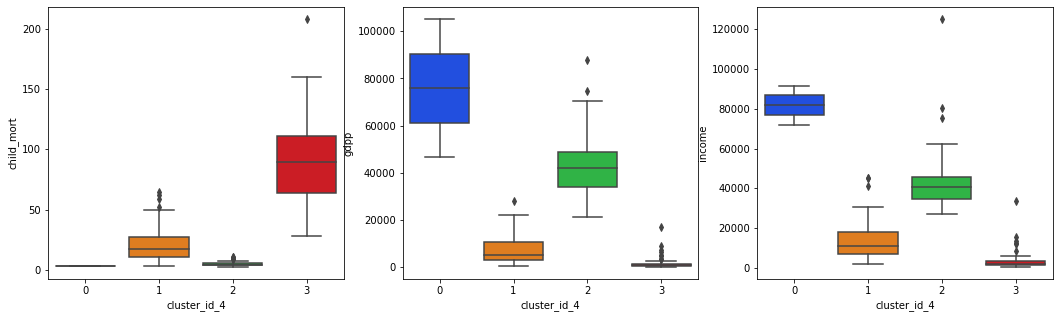

In [54]:
# Box plot on various variable against the CLUSTER_ID to visualize the spread of the data

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='cluster_id_4', y='child_mort',
            data=cntry_data_k, palette="bright")
plt.subplot(1, 3, 2)
sns.boxplot(x='cluster_id_4', y='gdpp',
            data=cntry_data_k, palette="bright")
plt.subplot(1, 3, 3)
sns.boxplot(x='cluster_id_4', y='income',
            data=cntry_data_k, palette="bright")

plt.show()

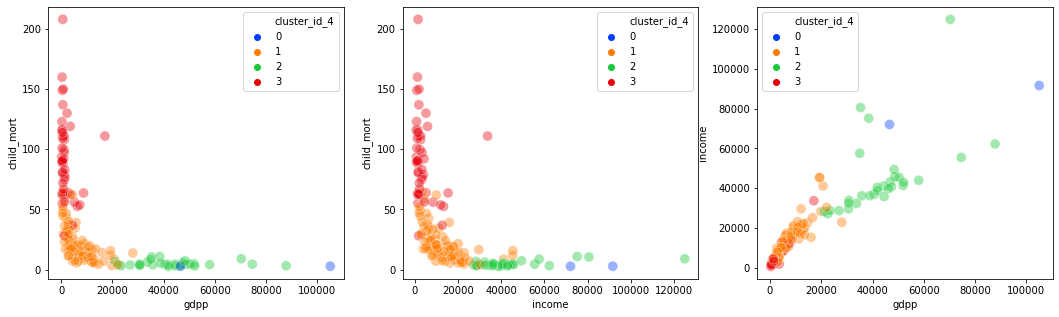

In [55]:
# Scatter plot on various variables to visualize the clusters based on them

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x='gdpp', y='child_mort', hue='cluster_id_4',
                data=cntry_data_k, legend='full', palette="bright", s=100, c='lightblue', alpha=.4)
plt.subplot(1, 3, 2)
sns.scatterplot(x='income', y='child_mort', hue='cluster_id_4',
                data=cntry_data_k, legend='full', palette="bright", s=100, c='lightblue', alpha=.4)
plt.subplot(1, 3, 3)
sns.scatterplot(x='gdpp', y='income', hue='cluster_id_4',
                data=cntry_data_k, legend='full', palette="bright", s=100, c='lightblue', alpha=.4)
plt.show()

In [56]:
# Checking the CLuster means:
cntry_data_k.groupby(['cluster_id_4']).mean().sort_values(['child_mort','income','gdpp'],ascending = [False,True,True])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_label_3,cluster_label_4,cluster_id_3
cluster_id_4,,,,,,,,,,,,
3,91.610417,879.063521,114.821765,827.028771,3897.354167,11.911146,59.239583,4.992083,1909.208333,0.000000,0.062500,2.000000
1,21.113793,3328.149408,460.000120,3404.497944,13297.586207,7.371506,73.147126,2.251954,7158.298851,0.000000,0.000000,0.000000
2,5.043333,21018.310000,4031.304333,17806.070000,45180.000000,2.764533,80.383333,1.799667,43300.000000,0.566667,0.566667,0.866667
0,2.800000,138475.000000,5001.930000,115092.000000,81900.000000,1.787000,82.000000,1.390000,75800.000000,1.500000,1.500000,1.000000


#### INSIGHT:
   - `Cluster 3` & `Cluster 1` seems to have highest child mortality rate and lowest income and lowest gdpp. Checking the countries in these clusters

In [57]:
# Checking the countries in Cluster 3 to see which are the countries in that segment.

cntry_data_k[['country','child_mort','income','gdpp']][cntry_data_k['cluster_id_4'] == 3].sort_values(['child_mort','income','gdpp'],ascending = [False,True,True])

,country,child_mort,income,gdpp
66,Haiti,208.0,1500,662
132,Sierra Leone,160.0,1220,399
32,Chad,150.0,1930,897
31,Central African Republic,149.0,888,446
97,Mali,137.0,1870,708
113,Nigeria,130.0,5150,2330
112,Niger,123.0,814,348
3,Angola,119.0,5900,3530
37,"Congo, Dem. Rep.",116.0,609,334
25,Burkina Faso,116.0,1430,575


In [58]:
# Checking the countries in Cluster 1 to see which are the countries in that segment.

cntry_data_k[['country','child_mort','income','gdpp']][cntry_data_k['cluster_id_4'] == 1].sort_values(['child_mort','income','gdpp'],ascending = [False,True,True])

,country,child_mort,income,gdpp
107,Myanmar,64.4,3720,988
154,Turkmenistan,62.0,9940,4440
69,India,58.8,4410,1350
146,Tajikistan,52.4,2110,738
12,Bangladesh,49.4,2440,758
...,...,...,...,...
14,Belarus,5.5,16200,6030
41,Croatia,5.5,20100,13500
51,Estonia,4.5,22700,14600
138,South Korea,4.1,30400,22100


#### Third Iteration - 5 clusters

In [59]:
# K Means with with k=5
kmeans_5 = KMeans(n_clusters=5, max_iter=500, init='k-means++', n_init=10, random_state= 335)
kmeans_5.fit(scaled_data)
kmeans_5.labels_

array([0, 3, 3, 0, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 0,
       3, 1, 3, 0, 0, 3, 0, 1, 3, 0, 0, 3, 3, 3, 0, 0, 0, 3, 0, 3, 1, 3,
       1, 3, 3, 3, 3, 0, 0, 3, 3, 1, 1, 0, 0, 3, 1, 0, 1, 3, 3, 0, 0, 3,
       0, 3, 1, 3, 3, 3, 0, 1, 1, 1, 3, 1, 3, 3, 0, 0, 1, 3, 0, 3, 3, 0,
       0, 3, 3, 2, 3, 0, 0, 3, 3, 0, 1, 0, 3, 3, 3, 3, 3, 3, 0, 3, 0, 3,
       1, 1, 0, 4, 1, 3, 0, 3, 3, 3, 3, 3, 3, 1, 3, 3, 0, 3, 3, 0, 3, 3,
       0, 1, 3, 1, 0, 0, 3, 1, 3, 3, 0, 3, 1, 1, 3, 0, 3, 0, 0, 3, 3, 3,
       3, 0, 3, 1, 1, 1, 3, 3, 3, 3, 3, 0, 0])

In [60]:
# assigning the label
cntry_data_k['cluster_id_5'] = kmeans_5.labels_
cntry_data_k.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_label_3,cluster_label_4,cluster_id_3,cluster_id_4,cluster_id_5
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,0,0,2,3,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,0,0,0,1,3
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,0,0,0,1,3
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,0,0,2,3,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,0,0,0,1,3


In [61]:
# Checking the number of countries in each cluster

cntry_data_k.cluster_id_5.value_counts()

3    88
0    47
1    30
4     1
2     1
Name: cluster_id_5, dtype: int64

In [62]:
## Visualizing the Clustered Data

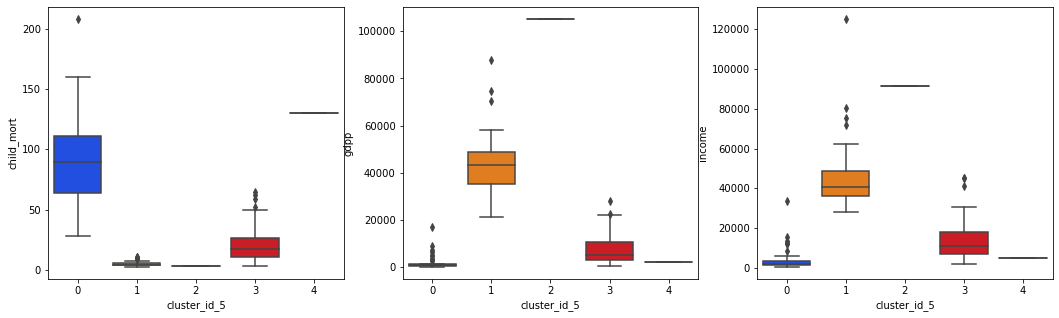

In [63]:
# Box plot on various variable against the CLUSTER_ID to visualize the spread of the data

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='cluster_id_5', y='child_mort',
            data=cntry_data_k, palette="bright")
plt.subplot(1, 3, 2)
sns.boxplot(x='cluster_id_5', y='gdpp',
            data=cntry_data_k, palette="bright")
plt.subplot(1, 3, 3)
sns.boxplot(x='cluster_id_5', y='income',
            data=cntry_data_k, palette="bright")

plt.show()

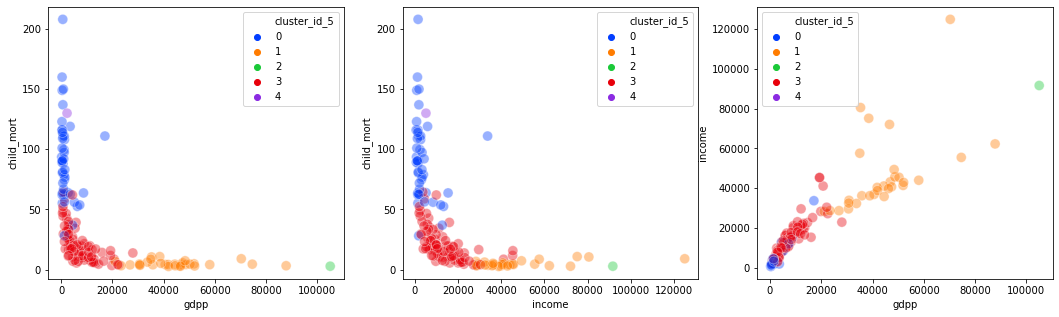

In [64]:
# Scatter plot on various variables to visualize the clusters based on them

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x='gdpp', y='child_mort', hue='cluster_id_5',
                data=cntry_data_k, legend='full', palette="bright", s=100, c='lightblue', alpha=.4)
plt.subplot(1, 3, 2)
sns.scatterplot(x='income', y='child_mort', hue='cluster_id_5',
                data=cntry_data_k, legend='full', palette="bright", s=100, c='lightblue', alpha=.4)
plt.subplot(1, 3, 3)
sns.scatterplot(x='gdpp', y='income', hue='cluster_id_5',
                data=cntry_data_k, legend='full', palette="bright", s=100, c='lightblue', alpha=.4)
plt.show()

In [65]:
# Checking the CLuster means:
cntry_data_k.groupby(['cluster_id_5']).mean().sort_values(['child_mort','income','gdpp'],ascending = [False,True,True])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_label_3,cluster_label_4,cluster_id_3,cluster_id_4
cluster_id_5,,,,,,,,,,,,,
4,130.000000,589.490000,118.131000,405.420000,5150.000000,104.000000,60.500000,5.840000,2330.000000,0.0,3.0,2.0,3.000000
0,90.793617,885.224660,114.751355,835.999170,3870.702128,9.951809,59.212766,4.974043,1900.255319,0.0,0.0,2.0,3.000000
3,20.918182,3366.778392,482.897845,3461.435467,13455.568182,7.295045,73.222727,2.242159,7332.636364,0.0,0.0,0.0,1.011364
1,5.006667,23900.726667,4010.316333,20228.370000,46676.666667,2.741567,80.480000,1.791667,44103.333333,0.6,0.6,0.9,1.933333
2,2.800000,183750.000000,8158.500000,149100.000000,91700.000000,3.620000,81.300000,1.630000,105000.000000,2.0,2.0,1.0,0.000000


#### INSIGHT: 
- Cluster 3 & Cluster 1 seems to have highest Child Mortality and lowest Income & GDPP. Lets check the countries in these clusters to see there outcome.

In [66]:
# Checking the countries in Cluster 3 to see which are the countries in that segment.

cntry_data_k[['country','child_mort','income','gdpp']][cntry_data_k['cluster_id_5'] == 4].sort_values(['child_mort','income','gdpp'],ascending = [False,True,True])

,country,child_mort,income,gdpp
113,Nigeria,130.0,5150,2330


In [67]:
# Checking the countries in Cluster 1 to see which are the countries in that segment.

cntry_data_k[['country','child_mort','income','gdpp']][cntry_data_k['cluster_id_5'] == 0].sort_values(['child_mort','income','gdpp'],ascending = [False,True,True])

,country,child_mort,income,gdpp
66,Haiti,208.0,1500,662
132,Sierra Leone,160.0,1220,399
32,Chad,150.0,1930,897
31,Central African Republic,149.0,888,446
97,Mali,137.0,1870,708
112,Niger,123.0,814,348
3,Angola,119.0,5900,3530
37,"Congo, Dem. Rep.",116.0,609,334
25,Burkina Faso,116.0,1430,575
64,Guinea-Bissau,114.0,1390,547


### Choosing the model

From the above 3 Iterations of K-Means, we could see that using 3 Clusters provided a better output in terms of a balanced cluster size. So we will consider the 'K-Means with 3 Clusters' as our FINAL MODEL

### Interpreting the Clusters from K-Means model

In [68]:
#New dataframe for group by & analysis

cntry_data_k_analysis =  cntry_data_k.groupby(['cluster_id_3']).mean().sort_values(['child_mort','income','gdpp'],ascending = [False,True,True])
cntry_data_k_analysis

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_label_3,cluster_label_4,cluster_id_4,cluster_id_5
cluster_id_3,,,,,,,,,,,,,
2,91.610417,879.063521,114.821765,827.028771,3897.354167,11.911146,59.239583,4.992083,1909.208333,0.000000,0.062500,3.000000,0.083333
0,20.357143,3604.149434,547.279455,3710.446386,13968.021978,7.070549,73.460440,2.235055,7979.912088,0.000000,0.000000,1.043956,2.934066
1,5.046429,31038.239286,4327.163214,25818.100000,50178.571429,3.014679,80.514286,1.760714,48114.285714,0.714286,0.714286,1.857143,1.035714


In [69]:
# Creating a new field for count of observations in each cluster

cntry_data_k_analysis['Observations']=cntry_data_k[['cluster_id_3','child_mort']].groupby(['cluster_id_3']).count()
cntry_data_k_analysis

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_label_3,cluster_label_4,cluster_id_4,cluster_id_5,Observations
cluster_id_3,,,,,,,,,,,,,,
2,91.610417,879.063521,114.821765,827.028771,3897.354167,11.911146,59.239583,4.992083,1909.208333,0.000000,0.062500,3.000000,0.083333,48
0,20.357143,3604.149434,547.279455,3710.446386,13968.021978,7.070549,73.460440,2.235055,7979.912088,0.000000,0.000000,1.043956,2.934066,91
1,5.046429,31038.239286,4327.163214,25818.100000,50178.571429,3.014679,80.514286,1.760714,48114.285714,0.714286,0.714286,1.857143,1.035714,28


In [70]:
# Creating a new field for proportion of observations in each cluster

cntry_data_k_analysis['Proportion']=round(cntry_data_k_analysis['Observations']/cntry_data_k_analysis['Observations'].sum(),2)


#Summary View
cntry_data_k_analysis[['child_mort','income','gdpp','Observations','Proportion']]

,child_mort,income,gdpp,Observations,Proportion
cluster_id_3,,,,,
2,91.610417,3897.354167,1909.208333,48,0.29
0,20.357143,13968.021978,7979.912088,91,0.54
1,5.046429,50178.571429,48114.285714,28,0.17


<Figure size 576x360 with 0 Axes>

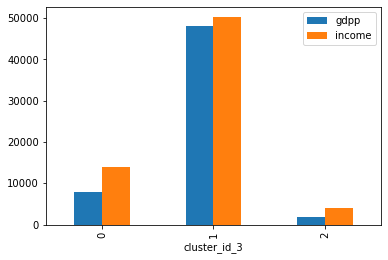

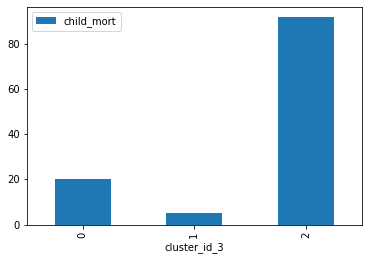

In [71]:
plt.figure(figsize=(8, 5))
cntry_data_k_plot1=cntry_data_k[['cluster_id_3','gdpp','income']].copy()
cntry_data_k_plot1=cntry_data_k_plot1.groupby('cluster_id_3').mean()
cntry_data_k_plot1.plot.bar()

cntry_data_k_plot2=cntry_data_k[['cluster_id_3','child_mort']].copy()
cntry_data_k_plot2=cntry_data_k_plot2.groupby('cluster_id_3').mean()
cntry_data_k_plot2.plot.bar()

`Interpretation of Clusters`
- `Cluster 2` has the `Highest average Child Mortality rate` of `~92` when compared to other 3 clusters, and `Lowest average GDPP & Income of ~ 1909 & 3897 respectively`. All these figures clearly makes this cluster the best candidate for the financial aid from NGO. 
- We could also see that `Cluster 2 comprises of ~29% of overall data`, and has `~48 observations in comparision to 167 total observations`

### Renaming the Clusters

In [72]:
cntry_data_k_analysis = cntry_data_k_analysis.rename({
    2: 'Under_Developed Countries',
    1: 'Developed Countries',
    0: 'Developing Countries'}).reset_index()

In [73]:
cntry_data_k_analysis[['cluster_id_3','child_mort','income','gdpp','Observations','Proportion']]

,cluster_id_3,child_mort,income,gdpp,Observations,Proportion
0,Under_Developed Countries,91.610417,3897.354167,1909.208333,48,0.29
1,Developing Countries,20.357143,13968.021978,7979.912088,91,0.54
2,Developed Countries,5.046429,50178.571429,48114.285714,28,0.17


In [74]:
cntry_data_k_analysis[['cluster_id_4','child_mort','income','gdpp','Observations','Proportion']]

,cluster_id_4,child_mort,income,gdpp,Observations,Proportion
0,3.000000,91.610417,3897.354167,1909.208333,48,0.29
1,1.043956,20.357143,13968.021978,7979.912088,91,0.54
2,1.857143,5.046429,50178.571429,48114.285714,28,0.17


`Final Cluster`
- Based on the above interpretation of the cluster, we now rename all the clusters accordingly.
- The `Cluster 2 now becomes 'Under Developed Countries'`, which will be of our interest.
- We will further analyse the Cluster 'Under Developed Countries' and get to know various metrics of that data set, based on which we could identify our final set of countries which needs the financial support from the NGO

### Analysing the 'Under Developed Countries' Cluster

In [75]:
# Countries in Cluster_id = 0, save to a new dataframe, this will form our final cluster data

final_cluster = cntry_data_k[cntry_data_k['cluster_id_3'] == 2].copy()
final_cluster = final_cluster[['country', 'child_mort', 'income', 'gdpp']]


In [76]:
final_cluster.sort_values([ 'gdpp', 'income','child_mort'], ascending=[True, True, False])

,country,child_mort,income,gdpp
26,Burundi,93.6,764,231
88,Liberia,89.3,700,327
37,"Congo, Dem. Rep.",116.0,609,334
112,Niger,123.0,814,348
132,Sierra Leone,160.0,1220,399
93,Madagascar,62.2,1390,413
106,Mozambique,101.0,918,419
31,Central African Republic,149.0,888,446
94,Malawi,90.5,1030,459
50,Eritrea,55.2,1420,482


### Decision Making on the final approach

In [77]:
final_cluster.describe()

,child_mort,income,gdpp
count,48.000000,48.000000,48.000000
mean,91.610417,3897.354167,1909.208333
std,34.319855,5590.168621,2925.911009
min,28.100000,609.000000,231.000000
25%,63.675000,1390.000000,551.500000
50%,89.750000,1860.000000,932.000000
75%,111.000000,3522.500000,1465.000000
max,208.000000,33700.000000,17100.000000


`NOTE`
- Looking at the descriptive statistics of our Under Developed Countries cluster, we could notice that some countries have really high income and gdpp values (looking at the max values of income & gdpp).
- From a business problem prespective, we would want our numbers of child mortality, income and gdpp somewhere around the MEDIAN level (We decided to go with MEDIAN and not MEAN, as there seems to be a greater variablity in the income and gdpp values). 
- So the approach we are going to take is to filter out all countries from our original list with income & gdpp less than the Median of 1860 & 932 respectively and Child Mortality >= the Median of 90. 
- We will perform the filtering in the order `GDPP --> INCOME --> CHILD MORTALITY`
- This is due to reason that, we need to identify the countries with lowest GDPP & INCOME first and then with maximum CHILD MORTALITY.

### Fetching the final data based on Cluster Median
Data less than median of gdpp of the cluster
`NOTE`
- We could see that the Median values of gdpp for 'Under Developed Countries' is ~932. We will take this as a benchmark and fetch all countries from our 'ORIGINAL dataframe with gdpp <= 932.

In [78]:
Under_Developed_Countries = cntry_df[cntry_df['gdpp'] <= 932].copy()
# Under_Developed_Countries = Under_Developed_Countries[Under_Developed_Countries['gdpp'] <= 932]
Under_Developed_Countries=Under_Developed_Countries.sort_values([ 'gdpp', 'income','child_mort'], ascending=[True, True, False])

In [79]:
Under_Developed_Countries[['country', 'child_mort', 'gdpp', 'income']]

,country,child_mort,gdpp,income
26,Burundi,93.6,231,764
88,Liberia,89.3,327,700
37,"Congo, Dem. Rep.",116.0,334,609
112,Niger,123.0,348,814
132,Sierra Leone,160.0,399,1220
93,Madagascar,62.2,413,1390
106,Mozambique,101.0,419,918
31,Central African Republic,149.0,446,888
94,Malawi,90.5,459,1030
50,Eritrea,55.2,482,1420


### Data less than median of income of the cluster

`NOTE`
- We could see that the Median values of income for 'Under Developed Countries' is ~932. We will take this as a benchmark and fetch all countries from our 'ORIGINAL dataframe with income <= 1860.

In [80]:
Under_Developed_Countries = Under_Developed_Countries[Under_Developed_Countries['income'] <= 1860]
Under_Developed_Countries=Under_Developed_Countries.sort_values([ 'gdpp', 'income','child_mort'], ascending=[True, True, False])

In [81]:
Under_Developed_Countries[['country', 'child_mort', 'gdpp', 'income']]

,country,child_mort,gdpp,income
26,Burundi,93.6,231,764
88,Liberia,89.3,327,700
37,"Congo, Dem. Rep.",116.0,334,609
112,Niger,123.0,348,814
132,Sierra Leone,160.0,399,1220
93,Madagascar,62.2,413,1390
106,Mozambique,101.0,419,918
31,Central African Republic,149.0,446,888
94,Malawi,90.5,459,1030
50,Eritrea,55.2,482,1420


### Data greater than median of child mortality rate of the final cluster
`NOTE` 
- We could see that the Median values of Child Mortality for 'Under Developed Countries' is ~90. We will take this as a benchmark and fetch all countries from our 'ORIGINAL dataframe with Child Mortality >= 90.

In [82]:
# We create a new dataframe to store the countries satisfying the cluster median from original dataframe

Under_Developed_Countries = Under_Developed_Countries[Under_Developed_Countries['child_mort'] >= 90]
Under_Developed_Countries=Under_Developed_Countries.sort_values([ 'gdpp', 'income','child_mort'], ascending=[True, True, False])

In [83]:
Under_Developed_Countries[['country', 'child_mort', 'gdpp', 'income']]

,country,child_mort,gdpp,income
26,Burundi,93.6,231,764
37,"Congo, Dem. Rep.",116.0,334,609
112,Niger,123.0,348,814
132,Sierra Leone,160.0,399,1220
106,Mozambique,101.0,419,918
31,Central African Republic,149.0,446,888
94,Malawi,90.5,459,1030
150,Togo,90.3,488,1210
64,Guinea-Bissau,114.0,547,1390
0,Afghanistan,90.2,553,1610


### Descriptive Statistics of Cluster 'Under_Developed_Countries'

In [84]:
# top 10 underdeveloped countries list to a new df

UDC_top_10=Under_Developed_Countries[['country', 'gdpp', 'income', 'child_mort']].head(10).copy()

In [85]:
#Final countries list

UDC_top_10

,country,gdpp,income,child_mort
26,Burundi,231,764,93.6
37,"Congo, Dem. Rep.",334,609,116.0
112,Niger,348,814,123.0
132,Sierra Leone,399,1220,160.0
106,Mozambique,419,918,101.0
31,Central African Republic,446,888,149.0
94,Malawi,459,1030,90.5
150,Togo,488,1210,90.3
64,Guinea-Bissau,547,1390,114.0
0,Afghanistan,553,1610,90.2


In [86]:
UDC_top_10.describe()

,gdpp,income,child_mort
count,10.00000,10.000000,10.00000
mean,422.40000,1045.300000,112.76000
std,99.62396,309.034356,25.11344
min,231.00000,609.000000,90.20000
25%,360.75000,832.500000,91.27500
50%,432.50000,974.000000,107.50000
75%,480.75000,1217.500000,121.25000
max,553.00000,1610.000000,160.00000


## Univariate Analysis of Cluster 'Under_Developed_Countries' (Top 10)

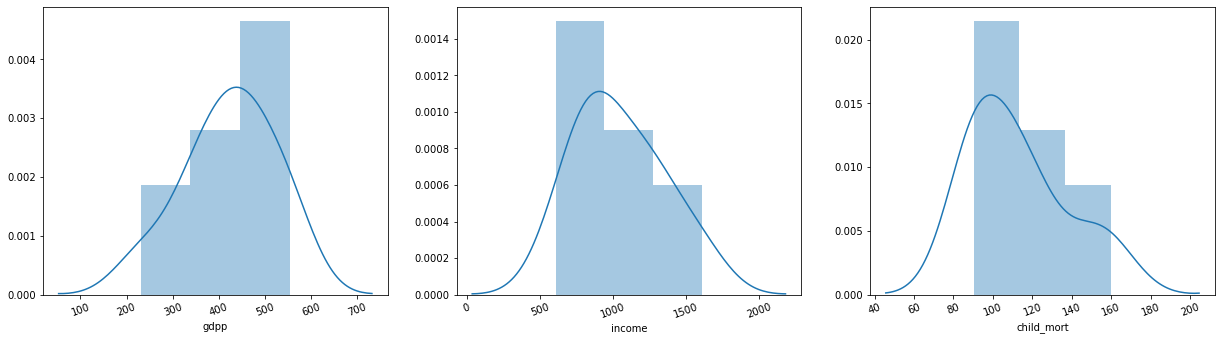

In [87]:
plt.figure(figsize=(21, 18))
features = ['gdpp','income','child_mort']
for i in enumerate(features):
    ax = plt.subplot(3, 3, i[0]+1)
    sns.distplot(UDC_top_10[i[1]])
    plt.xticks(rotation=20)

### Bivariate Analysis of Cluster 'Under_Developed_Countries' (Top 10)

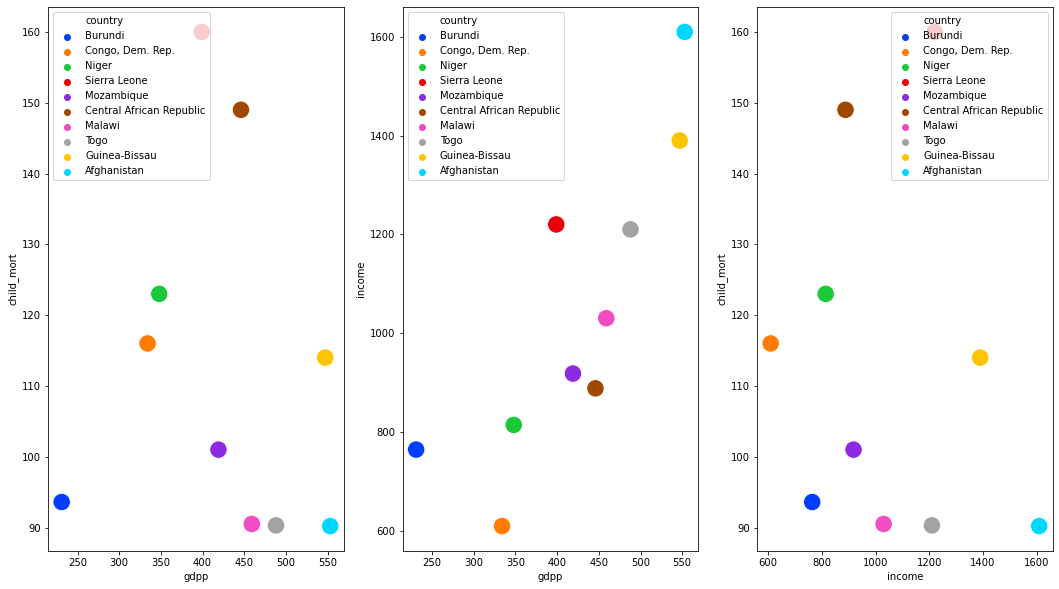

In [88]:
# Scatter plot on various variables to visualize the clusters based on them

plt.figure(figsize=(18, 10))
plt.subplot(1, 3, 1)
sns.scatterplot(x='gdpp', y='child_mort', hue='country',
                data=UDC_top_10, legend='full', palette="bright", s=300, c='lightblue')
plt.subplot(1, 3, 2)
sns.scatterplot(x='gdpp', y='income', hue='country',
                data=UDC_top_10, legend='full', palette="bright", s=300, c='lightblue')
plt.subplot(1, 3, 3)
sns.scatterplot(x='income', y='child_mort', hue='country',
                data=UDC_top_10, legend='full', palette="bright", s=300, c='lightblue')
plt.show()

## Conclusion & Recommendation
- We performed CLUSTERING on the socio-economic data provided for various countries to identify countries most eligible for Financial Aid from the NGO. 
- Based on Clustering Analysis, below are the top 10 countries under our 'Under Developed Countries' cluster which are in dire need of the Financial Aid. This output is purely based on the dataset provided and various analytical methodologies performed.

In [89]:
#TOP 10 COUNTRIES recommended for Financial Aid

UDC_top_10

,country,gdpp,income,child_mort
26,Burundi,231,764,93.6
37,"Congo, Dem. Rep.",334,609,116.0
112,Niger,348,814,123.0
132,Sierra Leone,399,1220,160.0
106,Mozambique,419,918,101.0
31,Central African Republic,446,888,149.0
94,Malawi,459,1030,90.5
150,Togo,488,1210,90.3
64,Guinea-Bissau,547,1390,114.0
0,Afghanistan,553,1610,90.2
